In [ ]:
import os
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import cftime
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import contextily as cx
import matplotlib.gridspec as gridspec

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.config import DICT_CIS_VULNERABILITY_FLOOD

from exactextract import exact_extract
from tqdm import tqdm

import scipy
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
tasmax_data_folder = Path(r"C:\Users\eks510\OneDrive - Vrije Universiteit Amsterdam\2_Projects\AFD_Serbia\Data\heat")
tasmax_data = list(tasmax_data_folder.glob("*.nc"))

# Filter files into separate lists based on patterns
obs_tasmax_files = [file for file in tasmax_data if 'obs_rx5d' in file.name]
rcp85_tasmax_files = [file for file in tasmax_data if 'rcp85' in file.name and 'tasmax' in file.name]
rcp45_tasmax_files = [file for file in tasmax_data if 'rcp45' in file.name and 'tasmax' in file.name]

In [ ]:
# Load country outline
world_path = r"C:\Data\Global_Geospatial\shapefiles\ne_10m_admin_0_countries.shp"
world = gpd.read_file(world_path)
country_plot = world.loc[world.SOV_A3 == 'SRB']

In [ ]:
def extract_model_name(file_path):
    """Extract clean model name from file path"""
    filename = file_path.name
    # Extract GCM and RCM parts
    gcm_part = filename.split('gcm-')[1].split('-rcm-')[0]
    rcm_part = filename.split('-rcm-')[1].split('.nc')[0]
    return f"{gcm_part}-{rcm_part}"

# Collect summer maximum temperature data
collect_tasmax = {}

for file_path in tqdm(rcp85_tasmax_files, desc="Processing tasmax files"):
    # Load dataset
    ds = xr.open_dataset(file_path).load()
    
    ds['tasmax'] = ds['tasmax'] - 273.15

    # Filter to summer months (May-September)
    summer_ds = ds.sel(time=ds.time.dt.month.isin([5, 6, 7, 8, 9]))
    
    # Get annual maximum within summer months
    annual_max = summer_ds.resample(time="1YS").max(dim="time")
    
    # Extract model name and store
    model_name = extract_model_name(file_path)
    collect_tasmax[model_name] = annual_max

Processing tasmax files: 100%|███████████████████████████████████████████████████████████| 8/8 [01:03<00:00,  7.92s/it]


In [ ]:
# # Collect summer maximum temperature data for RCP4.5
# collect_tasmax_rcp45 = {}

# for file_path in tqdm(rcp45_tasmax_files, desc="Processing RCP4.5 tasmax files"):
#     # Load dataset
#     ds = xr.open_dataset(file_path).load()
    
#     # Convert from Kelvin to Celsius
#     ds['tasmax'] = ds['tasmax'] - 273.15
    
#     # Filter to summer months (May-September)
#     summer_ds = ds.sel(time=ds.time.dt.month.isin([5, 6, 7, 8, 9]))
    
#     # Get annual maximum within summer months
#     annual_max = summer_ds.resample(time="1YS").max(dim="time")
    
#     # Extract model name and store
#     model_name = extract_model_name(file_path)
#     collect_tasmax_rcp45[model_name] = annual_max

In [ ]:
road_network = gpd.read_parquet('PERS_connected.parquet')

# Clip roads to country boundary
road_network = gpd.clip(road_network, country_plot)

In [ ]:
# Prepare road centroids (if not already done)
road_centroids = road_network.copy()
road_centroids['centroid'] = road_network.geometry.centroid
road_centroids['lon'] = road_centroids['centroid'].x
road_centroids['lat'] = road_centroids['centroid'].y

# Get all model names
model_names = list(collect_tasmax.keys())
print(f"Processing {len(model_names)} climate models:")
for name in model_names:
    print(f"  - {name}")

# Dictionary to store results for each model
all_model_results = {}

# Loop through all 8 climate models
for model_name in model_names:
    
    model_data = collect_tasmax[model_name]
    years = model_data.time.dt.year.values
    n_roads = len(road_centroids)
    n_years = len(years)
    
    # Create matrix to store results for this model
    exposure_matrix = np.zeros((n_roads, n_years))
    
    # Extract time series for each centroid
    for i, (idx, road) in enumerate(tqdm(road_centroids.iterrows(), 
                                        total=n_roads, 
                                        desc=f"Extracting centroids for {model_name}",
                                        leave=True)):
        # Extract full time series for this location
        temp_timeseries = model_data['tasmax'].sel(
            longitude=road['lon'], 
            latitude=road['lat'], 
            method='nearest'
        ).values
        
        exposure_matrix[i, :] = temp_timeseries
            
    
    # Create DataFrame for this model
    model_exposure_df = pd.DataFrame(
        exposure_matrix, 
        columns=years,
        index=road_centroids.index
    )
    
    # Store in dictionary
    all_model_results[model_name] = model_exposure_df
    

C:\Users\eks510\AppData\Local\Temp\ipykernel_11744\781061720.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_centroids['centroid'] = road_network.geometry.centroid


Processing 8 climate models:
  - ICHEC-EC-EARTH-CLMcom-CCLM4-8-17
  - ICHEC-EC-EARTH-DMI-HIRHAM5
  - ICHEC-EC-EARTH-KNMI-RACMO22E
  - MOHC-HadGEM2-ES-CLMcom-CCLM4-8-17
  - MOHC-HadGEM2-ES-KNMI-RACMO22E
  - MPI-M-MPI-ESM-LR-CLMcom-CCLM4-8-17
  - MPI-M-MPI-ESM-LR-MPI-CSC-REMO20091
  - MPI-M-MPI-ESM-LR-MPI-CSC-REMO20092


Extracting centroids for ICHEC-EC-EARTH-CLMcom-CCLM4-8-17: 100%|██████████████████| 3033/3033 [00:03<00:00, 785.93it/s]
Extracting centroids for ICHEC-EC-EARTH-DMI-HIRHAM5: 100%|███████████████████████| 3033/3033 [00:02<00:00, 1062.06it/s]
Extracting centroids for ICHEC-EC-EARTH-KNMI-RACMO22E: 100%|█████████████████████| 3033/3033 [00:02<00:00, 1051.18it/s]
Extracting centroids for MOHC-HadGEM2-ES-CLMcom-CCLM4-8-17: 100%|█████████████████| 3033/3033 [00:03<00:00, 812.55it/s]
Extracting centroids for MOHC-HadGEM2-ES-KNMI-RACMO22E: 100%|█████████████████████| 3033/3033 [00:03<00:00, 844.76it/s]
Extracting centroids for MPI-M-MPI-ESM-LR-CLMcom-CCLM4-8-17: 100%|████████████████| 3033/3033 [00:03<00:00, 977.94it/s]
Extracting centroids for MPI-M-MPI-ESM-LR-MPI-CSC-REMO20091: 100%|███████████████| 3033/3033 [00:01<00:00, 1556.55it/s]
Extracting centroids for MPI-M-MPI-ESM-LR-MPI-CSC-REMO20092: 100%|███████████████| 3033/3033 [00:02<00:00, 1482.21it/s]


In [ ]:
# Calculate centroids of road segments
road_centroids = road_network.copy()
road_centroids['centroid'] = road_network.geometry.centroid
road_centroids['lon'] = road_centroids['centroid'].x
road_centroids['lat'] = road_centroids['centroid'].y

# Select model data (all years at once)
selected_model = 'ICHEC-EC-EARTH-CLMcom-CCLM4-8-17'
model_data = collect_tasmax[selected_model]

# Extract temperature time series for all road centroids at once
print("Extracting temperature time series for all road segments...")

# Create arrays to store results
n_roads = len(road_centroids)
n_years = len(model_data.time)
exposure_matrix = np.zeros((n_roads, n_years))

# Extract time series for each centroid
for i, (idx, road) in enumerate(tqdm(road_centroids.iterrows(), total=n_roads, desc="Extracting centroids")):
    try:
        # Extract full time series for this location
        temp_timeseries = model_data['tasmax'].sel(
            longitude=road['lon'], 
            latitude=road['lat'], 
            method='nearest'
        ).values
        
        exposure_matrix[i, :] = temp_timeseries
        
    except Exception as e:
        print(f"Error for road {i}: {e}")
        exposure_matrix[i, :] = np.nan

# Create DataFrame with results
years = model_data.time.dt.year.values
exposure_df = pd.DataFrame(
    exposure_matrix, 
    columns=[f'{year}' for year in years],
    index=road_centroids.index
)

# Combine with original road network
road_exposure_results = pd.concat([road_network, exposure_df], axis=1)

C:\Users\eks510\AppData\Local\Temp\ipykernel_11744\3579053125.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_centroids['centroid'] = road_network.geometry.centroid


Extracting temperature time series for all road segments...


Extracting centroids: 100%|██████████████████████████████████████████████████████| 3033/3033 [00:02<00:00, 1097.53it/s]


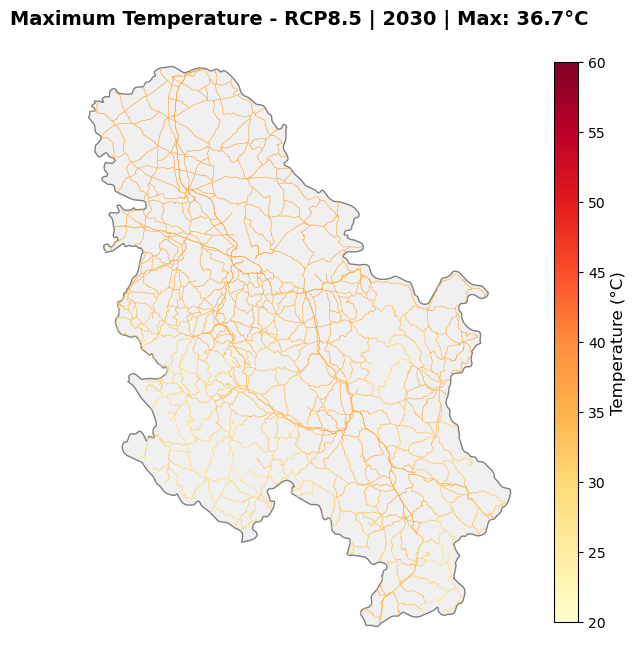

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Get years and temperature range
year_columns = [col for col in road_exposure_results.columns if str(col).isdigit()]
years = sorted([int(col) for col in year_columns])
filtered_years = [year for year in years if 2030 <= year <= 2100]

all_temps = []
for year in filtered_years:
    temps = road_exposure_results[str(year)].dropna()
    all_temps.extend(temps)

vmin, vmax = 20,60

# Create figure with space for colorbar
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(right=0.85)  # Make room for colorbar
ax.set_aspect('equal')
ax.axis('off')

# Create colorbar axis and colorbar ONCE
cbar_ax = fig.add_axes([0.7, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Temperature (°C)', fontsize=12)

def animate(frame):
    # Clear only the main axis, not the colorbar
    ax.clear()
    ax.set_aspect('equal')
    ax.axis('off')
    
    current_year = filtered_years[frame]
    
    # Calculate maximum temperature across all roads for this year
    max_temp = road_exposure_results[str(current_year)].max()
    
    # Plot country background with darker, more solid color
    country_plot.plot(ax=ax, color='#f0f0f0', edgecolor='#808080', alpha=1.0, linewidth=1)
    
    # Plot roads with temperature data using YlOrRd colormap
    road_exposure_results.plot(
        column=str(current_year),
        ax=ax,
        cmap='YlOrRd',
        vmin=vmin,
        vmax=vmax,
        linewidth=0.5,
        legend=False
    )
    
    # Add title with maximum temperature
    ax.set_title(f'Maximum Temperature - RCP8.5 | {current_year} | Max: {max_temp:.1f}°C', 
                 fontsize=14, fontweight='bold', pad=10)

# Create animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(filtered_years),
    interval=400,
    blit=False,
    repeat=True
)

# Save animation
ani.save('serbia_roads_temp_exposure.gif', 
         writer="imagemagick", 
         fps=5)

# Save animation

%%time

# Get model names and years
model_names = list(all_model_results.keys())

# Check the first model to see column structure
first_model = model_names[0]

# Get years from the original data (ensure consistent type)
years = list(all_model_results[first_model].columns)
filtered_years = [year for year in years if 2030 <= year <= 2100]

# Set temperature range
vmin, vmax = 20, 60

# Create figure with 4x2 subplot layout
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
fig.subplots_adjust(right=0.92, hspace=0.1, wspace=0.05)

# Create shared colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Temperature (°C)', fontsize=14)

# Optimize data preparation - ensure consistent column names
model_road_data = {}
for model_name in model_names:
    # Use concat to join geometry and temperature data efficiently
    model_data = pd.concat([
        road_network[['geometry']].reset_index(drop=True),  # Ensure clean index
        all_model_results[model_name].reset_index(drop=True)  # Ensure clean index
    ], axis=1)
    
    # Convert back to GeoDataFrame
    model_road_data[model_name] = gpd.GeoDataFrame(model_data)

def animate(frame):
    current_year = filtered_years[frame]
    
    # Clear all axes
    for ax in axes:
        ax.clear()
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Plot each model in its own subplot
    for i, model_name in enumerate(model_names):
        ax = axes[i]
        
        # Access using the actual column (year as int, not string)
        max_temp = model_road_data[model_name][current_year].max()
        
        # Plot country background
        country_plot.plot(ax=ax, color='#f0f0f0', edgecolor='#808080', alpha=1.0, linewidth=0.5)
        
        # Plot roads with temperature data
        model_road_data[model_name].plot(
            column=current_year,  # Use year as int, not string
            ax=ax,
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            linewidth=0.5,
            legend=False
        )
        
        # Add model title with max temp
        ax.set_title(f'{model_name}\n{current_year} | Max: {max_temp:.1f}°C', 
                     fontsize=10, fontweight='bold')
    
    # Add overall title
    fig.suptitle(f'Road Network Temperature Exposure - RCP8.5 - {current_year}', 
                 fontsize=16, fontweight='bold', y=0.95)

# Create animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(filtered_years),
    interval=500,
    blit=False,
    repeat=True
)

#Save animation 
ani.save('serbia_roads_all_models_rcp85.gif', 
         writer="imagemagick", 
         fps=3)

plt.show()

In [ ]:
loan_links = pd.read_excel('afd_segments.xlsx')
loan_sections = road_network.loc[road_network.feature_code.isin(loan_links.Link_ID.astype('str').values)]

In [ ]:
road_segments = dict(zip(
    loan_sections.section_description.values,
    loan_sections.centroid.apply(lambda pt: (pt.x, pt.y)).values
))

C:\Users\eks510\AppData\Local\Temp\ipykernel_11744\2184742117.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loan_sections.centroid.apply(lambda pt: (pt.x, pt.y)).values


In [ ]:
unique_sections = loan_sections.section_description.unique()

color_dict = dict(zip(unique_sections, [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', 
    '#00FFFF', '#FF8000', '#8000FF', '#0080FF', '#FF0080', 
    '#80FF00', '#FF8080', '#8080FF', '#FF8040'
]))

C:\Users\eks510\AppData\Local\Temp\ipykernel_11744\157341775.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loan_sections.centroid.apply(lambda pt: (pt.x, pt.y)).values


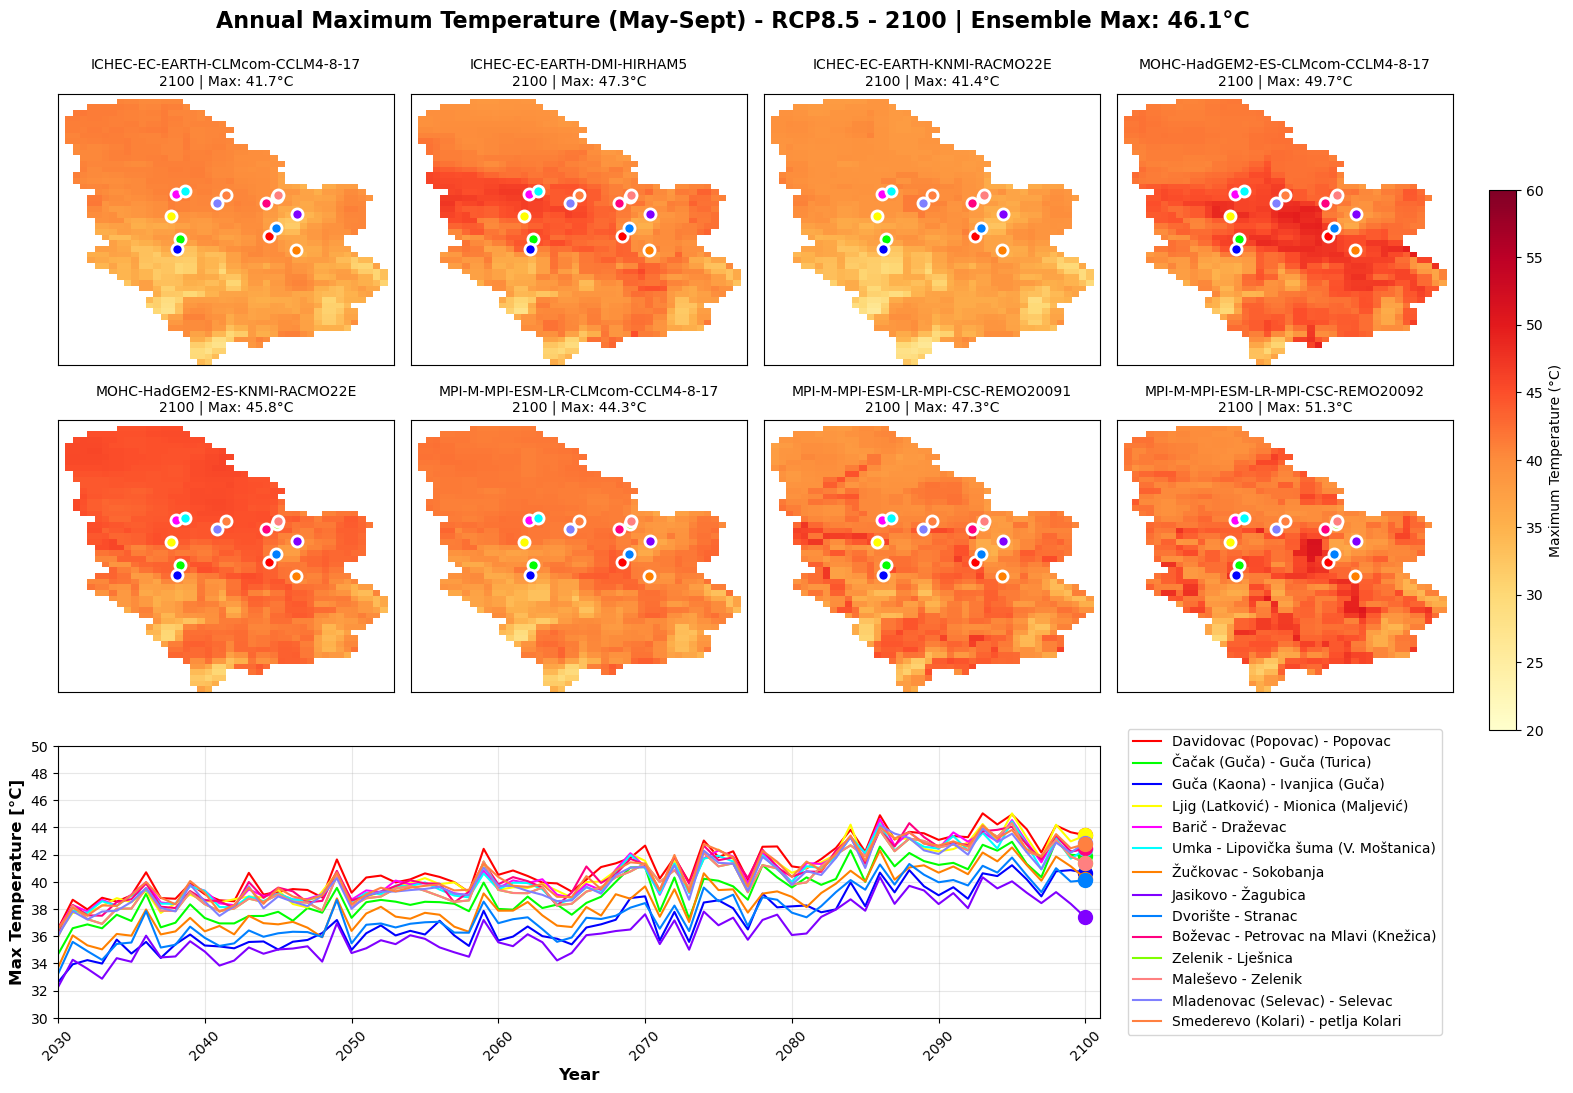

In [ ]:
# Define Serbian city coordinates (lon, lat)
# cities = {
#     'Belgrade': (20.46, 44.82),
#     'Novi Sad': (19.85, 45.25),
#     'Niš': (21.90, 43.32)
# }

road_segments = dict(zip(
    loan_sections.section_description.values,
    loan_sections.centroid.apply(lambda pt: (pt.x, pt.y)).values
))

# Filter data to 2030-2100 and prepare for animation
start_year = 2030
end_year = 2100

# Filter datasets to our year range (already converted to Celsius)
filtered_tasmax = {}
model_names = list(collect_tasmax.keys())

for model_name, ds in collect_tasmax.items():
    ds_filtered = ds.sel(time=ds.time.dt.year.isin(range(start_year, end_year + 1)))
    filtered_tasmax[model_name] = ds_filtered

# Get coordinate arrays and years
first_model = model_names[0]
lons = filtered_tasmax[first_model].longitude.values
lats = filtered_tasmax[first_model].latitude.values
years = filtered_tasmax[first_model].time.dt.year.values

# Extract temperature data for each city from each model
city_temps = {}
for city_name, (lon, lat) in road_segments.items():
    city_model_temps = []
    for model_name in model_names:
        city_temp = filtered_tasmax[model_name]['tasmax'].sel(longitude=lon, latitude=lat, method='nearest').values
        city_model_temps.append(city_temp)
    # Calculate ensemble mean across models
    city_temps[city_name] = np.mean(city_model_temps, axis=0)

# Create figure with GridSpec
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[3, 3, 3], hspace=0.2, wspace=0.05)

# Create map subplots (top two rows)
map_axes = []
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        map_axes.append(ax)

# Create line plot subplot (bottom row)
ax_line = fig.add_subplot(gs[2, :3])
ax_legend = fig.add_subplot(gs[2, 3])

# Create space for shared colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.015, 0.45])

# Create initial plots
im_plots = []
for i, model_name in enumerate(model_names):
    ax = map_axes[i]
    
    # Initial data (first year)
    initial_data = filtered_tasmax[model_name]['tasmax'].isel(time=0).values
    
    im = ax.imshow(initial_data, cmap='YlOrRd', vmin=20, vmax=60, 
                   extent=[lons.min(), lons.max(), lats.min(), lats.max()], 
                   origin='lower', aspect='auto')
    
    ax.set_title(f"{model_name}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    im_plots.append(im)

# Add shared colorbar
fig.colorbar(im_plots[0], cax=cbar_ax, label='Maximum Temperature (°C)')
cbar_ax.set_yticks(np.arange(20, 65, 5))

# Add city markers to each map
for city_name, (lon, lat) in road_segments.items():
    for ax in map_axes:
        ax.plot(lon, lat, 'o', color=color_dict[city_name], 
                markersize=8, markeredgecolor='white', markeredgewidth=2,
                zorder=10)

# Set up line plot
ax_line.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_line.set_ylabel('Max Temperature [°C]', fontsize=12, fontweight='bold')
ax_line.set_xlim(0, len(years))

# Calculate y-axis limits based on city data
all_temps = np.concatenate([road_segments[city] for city in road_segments.keys()])
ymin = np.nanmin(all_temps) - 2
ymax = np.nanmax(all_temps) + 2
ax_line.set_ylim(30, 50)
ax_line.set_yticks(np.arange(30, 51, 2))  # Ticks from 35 to 45 with interval of 2
ax_line.grid(alpha=0.3)

# Create empty line objects for cities
lines = {}
dots = {}
for city_name, color in color_dict.items():
    line, = ax_line.plot([], [], color=color, linewidth=1.5, label=city_name)
    dot, = ax_line.plot([], [], 'o', color=color, markersize=10)
    lines[city_name] = line
    dots[city_name] = dot

# Create legend in separate subplot
ax_legend.legend(handles=list(lines.values()), labels=list(color_dict.keys()), 
                loc='center', fontsize=10)
ax_legend.axis('off')  # Hide axes for legend subplot

# Set x-axis labels
xtick_positions = range(0, len(years), 10)
xtick_labels = [str(years[i]) for i in xtick_positions]
ax_line.set_xticks(xtick_positions)
ax_line.set_xticklabels(xtick_labels, rotation=45)

def animate(frame):
    current_year = years[frame]
    
    # Calculate ensemble mean max temperature for this frame
    frame_temps = []
    for model_name in model_names:
        model_max = filtered_tasmax[model_name]['tasmax'].isel(time=frame).max().values
        frame_temps.append(model_max)
    
    ensemble_mean_max = np.nanmean(frame_temps)
    
    # Update each map subplot
    for i, model_name in enumerate(model_names):
        data = filtered_tasmax[model_name]['tasmax'].isel(time=frame).values
        model_max = filtered_tasmax[model_name]['tasmax'].isel(time=frame).max().values
        im_plots[i].set_data(data)
        map_axes[i].set_title(f"{model_name}\n{current_year} | Max: {model_max:.1f}°C", fontsize=10)
    
    # Update main title
    fig.suptitle(f'Annual Maximum Temperature (May-Sept) - RCP8.5 - {current_year} | '
                 f'Ensemble Max: {ensemble_mean_max:.1f}°C', 
                 fontsize=16, y=0.95, weight='bold')
    
    # Update line plot - show data up to current frame
    x_data = list(range(frame + 1))
    
    # Update lines and dots for cities
    for city_name in road_segments.keys():
        lines[city_name].set_data(x_data, city_temps[city_name][:frame+1])
        dots[city_name].set_data([frame], [city_temps[city_name][frame]])
    
    return im_plots + list(lines.values()) + list(dots.values())

# Create animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(years),
    interval=300,
    blit=True
)

# Save animation
ani.save('tasmax_cities_rcp85_2030-2100.gif', 
         writer="pillow", 
         savefig_kwargs={'facecolor': 'white', 'pad_inches': 0.1})


In [ ]:
# Define Serbian city coordinates (lon, lat)
cities = {
    'Belgrade': (20.46, 44.82),
    'Novi Sad': (19.85, 45.25),
    'Niš': (21.90, 43.32)
}

# Filter data to 2030-2100 and prepare for animation
start_year = 2030
end_year = 2100

# Filter datasets to our year range (already converted to Celsius)
filtered_tasmax_rcp45 = {}
model_names = list(collect_tasmax_rcp45.keys())

for model_name, ds in collect_tasmax_rcp45.items():
    ds_filtered = ds.sel(time=ds.time.dt.year.isin(range(start_year, end_year + 1)))
    filtered_tasmax_rcp45[model_name] = ds_filtered

# Get coordinate arrays and years
first_model = model_names[0]
lons = filtered_tasmax_rcp45[first_model].longitude.values
lats = filtered_tasmax_rcp45[first_model].latitude.values
years = filtered_tasmax_rcp45[first_model].time.dt.year.values

# Extract temperature data for each city from each model
city_temps = {}
for city_name, (lon, lat) in cities.items():
    city_model_temps = []
    for model_name in model_names:
        city_temp = filtered_tasmax_rcp45[model_name]['tasmax'].sel(longitude=lon, latitude=lat, method='nearest').values
        city_model_temps.append(city_temp)
    # Calculate ensemble mean across models
    city_temps[city_name] = np.mean(city_model_temps, axis=0)

# Create figure with GridSpec
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[3, 3, 1.3], hspace=0.2, wspace=0.05)

# Create map subplots (top two rows)
map_axes = []
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        map_axes.append(ax)

# Create line plot subplot (bottom row)
ax_line = fig.add_subplot(gs[2, :])

# Create space for shared colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.015, 0.45])

# Create initial plots
im_plots = []
for i, model_name in enumerate(model_names):
    ax = map_axes[i]
    
    # Initial data (first year)
    initial_data = filtered_tasmax_rcp45[model_name]['tasmax'].isel(time=0).values
    
    im = ax.imshow(initial_data, cmap='YlOrRd', vmin=20, vmax=60, 
                   extent=[lons.min(), lons.max(), lats.min(), lats.max()], 
                   origin='lower', aspect='auto')
    
    ax.set_title(f"{model_name}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    im_plots.append(im)

# Add shared colorbar
fig.colorbar(im_plots[0], cax=cbar_ax, label='Maximum Temperature (°C)')
cbar_ax.set_yticks(np.arange(20, 65, 5))

# Add city markers to each map
city_colors = {'Belgrade': '#003049', 'Novi Sad': '#5f0f40', 'Niš': '#386641'}
for city_name, (lon, lat) in cities.items():
    for ax in map_axes:
        ax.plot(lon, lat, 'o', color=city_colors[city_name], 
                markersize=8, markeredgecolor='white', markeredgewidth=2,
                zorder=10)

# Set up line plot
ax_line.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_line.set_ylabel('Max Temperature [°C]', fontsize=12, fontweight='bold')
ax_line.set_xlim(0, len(years))

# Set y-axis limits and ticks for temperature range
ax_line.set_ylim(35, 45)
ax_line.set_yticks(np.arange(35, 47, 2))  # Ticks from 35 to 45 with interval of 2
ax_line.grid(alpha=0.3)

# Create empty line objects for cities
lines = {}
dots = {}
for city_name, color in city_colors.items():
    line, = ax_line.plot([], [], color=color, linewidth=2.5, label=city_name)
    dot, = ax_line.plot([], [], 'o', color=color, markersize=10)
    lines[city_name] = line
    dots[city_name] = dot

ax_line.legend(loc='upper left', fontsize=11)

# Set x-axis labels
xtick_positions = range(0, len(years), 10)
xtick_labels = [str(years[i]) for i in xtick_positions]
ax_line.set_xticks(xtick_positions)
ax_line.set_xticklabels(xtick_labels, rotation=45)

def animate(frame):
    current_year = years[frame]
    
    # Calculate ensemble mean max temperature for this frame
    frame_temps = []
    for model_name in model_names:
        model_max = filtered_tasmax_rcp45[model_name]['tasmax'].isel(time=frame).max().values
        frame_temps.append(model_max)
    
    ensemble_mean_max = np.nanmean(frame_temps)
    
    # Update each map subplot
    for i, model_name in enumerate(model_names):
        data = filtered_tasmax_rcp45[model_name]['tasmax'].isel(time=frame).values
        model_max = filtered_tasmax_rcp45[model_name]['tasmax'].isel(time=frame).max().values
        im_plots[i].set_data(data)
        map_axes[i].set_title(f"{model_name}\n{current_year} | Max: {model_max:.1f}°C", fontsize=10)
    
    # Update main title
    fig.suptitle(f'Annual Maximum Temperature (May-Sept) - RCP4.5 - {current_year} | '
                 f'Ensemble Mean Max: {ensemble_mean_max:.1f}°C', 
                 fontsize=16, y=0.95, weight='bold')
    
    # Update line plot - show data up to current frame
    x_data = list(range(frame + 1))
    
    # Update lines and dots for cities
    for city_name in cities.keys():
        lines[city_name].set_data(x_data, city_temps[city_name][:frame+1])
        dots[city_name].set_data([frame], [city_temps[city_name][frame]])
    
    return im_plots + list(lines.values()) + list(dots.values())

# Create animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(years),
    interval=300,
    blit=True
)

# Save animation
ani.save('tasmax_cities_rcp45_2030-2100.gif', 
         writer="pillow", 
         savefig_kwargs={'facecolor': 'white', 'pad_inches': 0.1})

plt.show()

NameError: name 'collect_tasmax_rcp45' is not defined

<timed exec>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



CPU times: total: 26min 58s
Wall time: 30min 37s


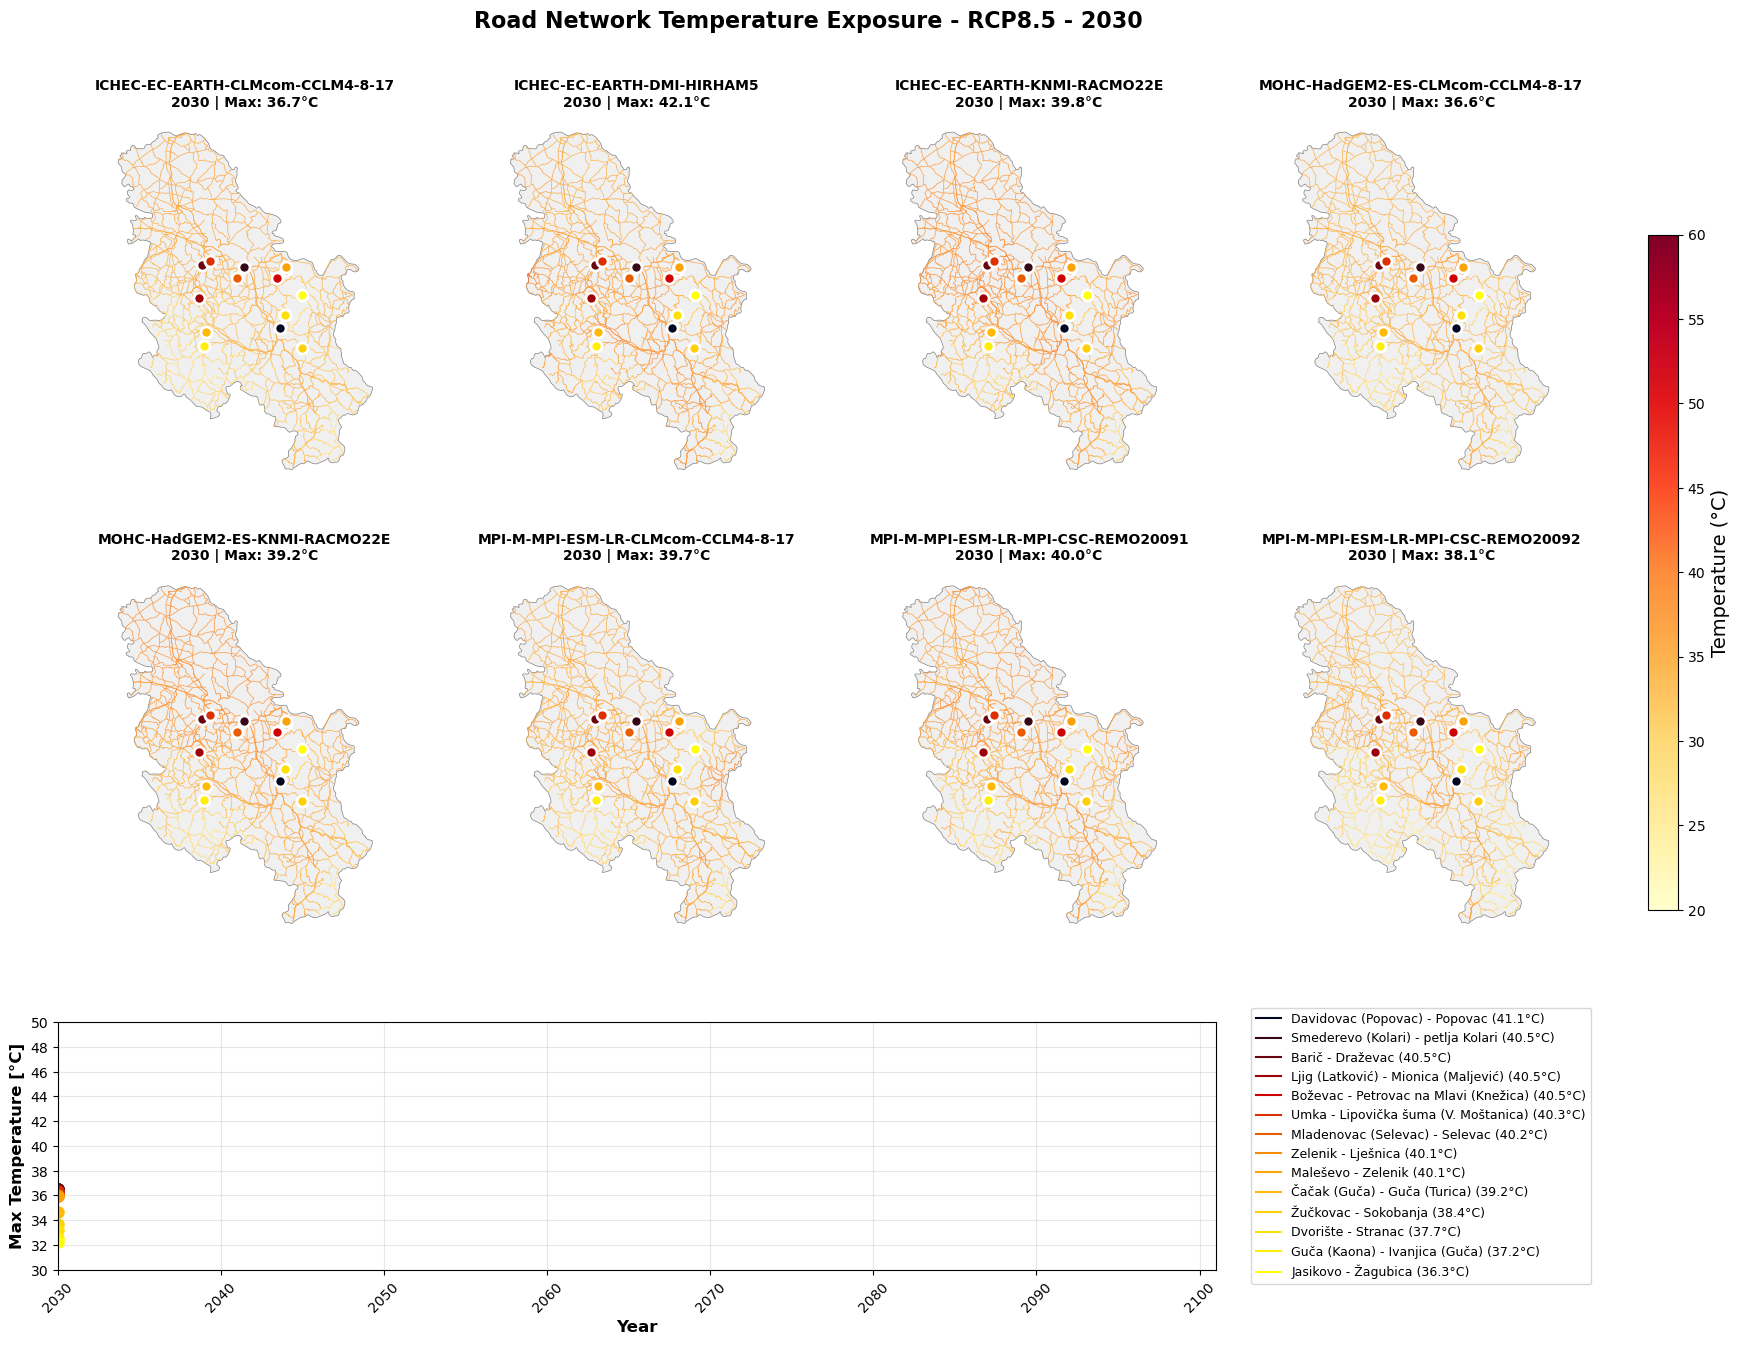

In [ ]:
%%time
# Use your existing road_segments
road_segments = dict(zip(
    loan_sections.section_description.values,
    loan_sections.centroid.apply(lambda pt: (pt.x, pt.y)).values
))

# Filter data to 2030-2100
start_year = 2030
end_year = 2100
model_names = list(all_model_results.keys())
filtered_years = [year for year in all_model_results[model_names[0]].columns if start_year <= year <= end_year]

# Extract temperature data for each road segment from each model
segment_temps = {}
for segment_name in road_segments.keys():
    segment_row = loan_sections[loan_sections.section_description == segment_name]
    if not segment_row.empty:
        segment_idx = segment_row.index[0]
        
        segment_model_temps = []
        for model_name in model_names:
            segment_temp_series = []
            for year in filtered_years:
                temp_value = all_model_results[model_name].loc[segment_idx, year]
                segment_temp_series.append(temp_value)
            segment_model_temps.append(segment_temp_series)
        
        # Calculate ensemble mean across models
        segment_temps[segment_name] = np.mean(segment_model_temps, axis=0)

# Calculate mean temperature for each segment (for ordering)
segment_mean_temps = {}
for segment_name, temps in segment_temps.items():
    segment_mean_temps[segment_name] = np.mean(temps)

# Sort segments by mean temperature (highest to lowest)
sorted_segments = sorted(segment_mean_temps.keys(), key=lambda x: segment_mean_temps[x], reverse=True)

# Expanded color palette from dark to light (14 colors)
color_palette = [
    "#03071e", "#370617", "#6a040f", "#9d0208", "#d00000", 
    "#dc2f02", "#e85d04", "#f48c06", "#faa307", "#ffba08",
    "#ffcf08", "#ffdf08", "#ffef08", "#ffff08"
]

# Create color dictionary ordered by temperature (highest temp = darkest color)
color_dict = {}
for i, segment_name in enumerate(sorted_segments):
    color_dict[segment_name] = color_palette[i % len(color_palette)]

# Set temperature range
vmin, vmax = 20, 60

# Prepare model road data for visualization
model_road_data = {}
for model_name in model_names:
    model_data = pd.concat([
        road_network[['geometry']].reset_index(drop=True),
        all_model_results[model_name].reset_index(drop=True)
    ], axis=1)
    model_road_data[model_name] = gpd.GeoDataFrame(model_data)

# Create figure with GridSpec
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 4, height_ratios=[3, 3, 2], hspace=0.25, wspace=0.05)

# Create map subplots (top two rows)
map_axes = []
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        map_axes.append(ax)

# Create line plot subplot (bottom row, first 3 columns)
ax_line = fig.add_subplot(gs[2, :3])
# Create legend subplot (bottom row, 4th column)  
ax_legend = fig.add_subplot(gs[2, 3])

# Create space for shared colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.015, 0.45])

# Create shared colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Temperature (°C)', fontsize=14)

# Set up line plot
ax_line.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_line.set_ylabel('Max Temperature [°C]', fontsize=12, fontweight='bold')
ax_line.set_xlim(0, len(filtered_years))

# Calculate y-axis limits
all_temps = np.concatenate([segment_temps[segment] for segment in segment_temps.keys()])
ax_line.set_ylim(30, 50)
ax_line.set_yticks(np.arange(30, 51, 2))
ax_line.grid(alpha=0.3)

# Create empty line objects for road segments (in temperature order)
lines = {}
dots = {}
for segment_name in sorted_segments:
    if segment_name in segment_temps:
        color = color_dict[segment_name]
        line, = ax_line.plot([], [], color=color, linewidth=1.5, 
                           label=f'{segment_name} ({segment_mean_temps[segment_name]:.1f}°C)')
        dot, = ax_line.plot([], [], 'o', color=color, markersize=8)
        lines[segment_name] = line
        dots[segment_name] = dot

# Create legend in separate subplot (ordered by temperature)
legend_handles = [lines[segment] for segment in sorted_segments if segment in lines]
legend_labels = [f'{segment} ({segment_mean_temps[segment]:.1f}°C)' 
                for segment in sorted_segments if segment in lines]

ax_legend.legend(handles=legend_handles, labels=legend_labels,
                loc='center', fontsize=9)
ax_legend.axis('off')

# Set x-axis labels
xtick_positions = range(0, len(filtered_years), 10)
xtick_labels = [str(filtered_years[i]) for i in xtick_positions]
ax_line.set_xticks(xtick_positions)
ax_line.set_xticklabels(xtick_labels, rotation=45)

def animate(frame):
    current_year = filtered_years[frame]
    
    # Clear all map axes
    for ax in map_axes:
        ax.clear()
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Plot each model in its own subplot
    for i, model_name in enumerate(model_names):
        ax = map_axes[i]
        
        # Get max temp for this model and year
        max_temp = model_road_data[model_name][current_year].max()
        
        # Plot country background
        country_plot.plot(ax=ax, color='#f0f0f0', edgecolor='#808080', alpha=1.0, linewidth=0.5)
        
        # Plot roads with temperature data
        model_road_data[model_name].plot(
            column=current_year,
            ax=ax,
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            linewidth=0.5,
            legend=False
        )
        
        # Add road segment markers
        for segment_name, (lon, lat) in road_segments.items():
            if segment_name in color_dict:
                ax.plot(lon, lat, 'o', color=color_dict[segment_name], 
                        markersize=8, markeredgecolor='white', markeredgewidth=2,
                        zorder=10)
        
        # Add model title with max temp
        ax.set_title(f'{model_name}\n{current_year} | Max: {max_temp:.1f}°C', 
                     fontsize=10, fontweight='bold')
    
    # Update main title
    fig.suptitle(f'Road Network Temperature Exposure - RCP8.5 - {current_year}', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Update line plot - show data up to current frame
    x_data = list(range(frame + 1))
    
    # Update lines and dots for road segments
    for segment_name in segment_temps.keys():
        if segment_name in lines:
            lines[segment_name].set_data(x_data, segment_temps[segment_name][:frame+1])
            dots[segment_name].set_data([frame], [segment_temps[segment_name][frame]])
    
    return list(lines.values()) + list(dots.values())

# Create animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(filtered_years),
    interval=500,
    blit=False,
    repeat=True
)

# Save animation 
ani.save('serbia_roads_with_segments_rcp85.gif', 
         writer="imagemagick", 
         fps=3,
         savefig_kwargs={'facecolor': 'white', 'pad_inches': 0.1})

In [ ]:
local_loans = gpd.read_parquet(r"C:\Users\eks510\OneDrive - Vrije Universiteit Amsterdam\2_Projects\AFD_Serbia\Data\local_road_loan_segments.parquet")[:105]
local_loans = local_loans.dissolve('section_id').reset_index()

In [ ]:
# Prepare road centroids (if not already done)
road_centroids = local_loans.copy()
road_centroids['centroid'] = local_loans.geometry.centroid
road_centroids['lon'] = road_centroids['centroid'].x
road_centroids['lat'] = road_centroids['centroid'].y

# Get all model names
model_names = list(collect_tasmax.keys())
print(f"Processing {len(model_names)} climate models:")
for name in model_names:
    print(f"  - {name}")

# Dictionary to store results for each model
all_local_loans_results = {}

# Loop through all 8 climate models
for model_name in model_names:
    
    model_data = collect_tasmax[model_name]
    years = model_data.time.dt.year.values
    n_roads = len(road_centroids)
    n_years = len(years)
    
    # Create matrix to store results for this model
    exposure_matrix = np.zeros((n_roads, n_years))
    
    # Extract time series for each centroid
    for i, (idx, road) in enumerate(tqdm(road_centroids.iterrows(), 
                                        total=n_roads, 
                                        desc=f"Extracting centroids for {model_name}",
                                        leave=True)):
        # Extract full time series for this location
        temp_timeseries = model_data['tasmax'].sel(
            longitude=road['lon'], 
            latitude=road['lat'], 
            method='nearest'
        ).values
        
        exposure_matrix[i, :] = temp_timeseries
            
    
    # Create DataFrame for this model
    model_exposure_df = pd.DataFrame(
        exposure_matrix, 
        columns=years,
        index=road_centroids.index
    )
    
    # Store in dictionary
    all_local_loans_results[model_name] = model_exposure_df
    

C:\Users\eks510\AppData\Local\Temp\ipykernel_11744\3768702513.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_centroids['centroid'] = local_loans.geometry.centroid


Processing 8 climate models:
  - ICHEC-EC-EARTH-CLMcom-CCLM4-8-17
  - ICHEC-EC-EARTH-DMI-HIRHAM5
  - ICHEC-EC-EARTH-KNMI-RACMO22E
  - MOHC-HadGEM2-ES-CLMcom-CCLM4-8-17
  - MOHC-HadGEM2-ES-KNMI-RACMO22E
  - MPI-M-MPI-ESM-LR-CLMcom-CCLM4-8-17
  - MPI-M-MPI-ESM-LR-MPI-CSC-REMO20091
  - MPI-M-MPI-ESM-LR-MPI-CSC-REMO20092


Extracting centroids for ICHEC-EC-EARTH-CLMcom-CCLM4-8-17: 100%|███████████████████████████████| 11/11 [00:00<?, ?it/s]
Extracting centroids for ICHEC-EC-EARTH-DMI-HIRHAM5: 100%|███████████████████████████| 11/11 [00:00<00:00, 1601.27it/s]
Extracting centroids for ICHEC-EC-EARTH-KNMI-RACMO22E: 100%|█████████████████████████| 11/11 [00:00<00:00, 1469.39it/s]
Extracting centroids for MOHC-HadGEM2-ES-CLMcom-CCLM4-8-17: 100%|████████████████████| 11/11 [00:00<00:00, 2662.44it/s]
Extracting centroids for MOHC-HadGEM2-ES-KNMI-RACMO22E: 100%|████████████████████████| 11/11 [00:00<00:00, 2430.71it/s]
Extracting centroids for MPI-M-MPI-ESM-LR-CLMcom-CCLM4-8-17: 100%|████████████████████| 11/11 [00:00<00:00, 861.11it/s]
Extracting centroids for MPI-M-MPI-ESM-LR-MPI-CSC-REMO20091: 100%|████████████████████| 11/11 [00:00<00:00, 992.86it/s]
Extracting centroids for MPI-M-MPI-ESM-LR-MPI-CSC-REMO20092: 100%|███████████████████| 11/11 [00:00<00:00, 2246.44it/s]


In [ ]:
# Create loan sections dictionary with coordinates
loan_segments = dict(zip(
    local_loans.section_id.values,
    local_loans.centroid.apply(lambda pt: (pt.x, pt.y)).values
))

# Create color dictionary for loan sections
color_palette = plt.cm.Set3(np.linspace(0, 1, len(loan_segments)))
color_dict = dict(zip(loan_segments.keys(), color_palette))

# Filter data to 2030-2100 and prepare for animation
start_year = 2030
end_year = 2100

# Filter datasets to our year range
filtered_tasmax = {}
model_names = list(collect_tasmax.keys())
for model_name, ds in collect_tasmax.items():
    ds_filtered = ds.sel(time=ds.time.dt.year.isin(range(start_year, end_year + 1)))
    filtered_tasmax[model_name] = ds_filtered

# Get coordinate arrays and years
first_model = model_names[0]
lons = filtered_tasmax[first_model].longitude.values
lats = filtered_tasmax[first_model].latitude.values
years = filtered_tasmax[first_model].time.dt.year.values

# Extract temperature data for each loan section from all_local_loans_results
section_temps = {}
for section_name in loan_segments.keys():
    # Get data for this section from all models
    section_model_temps = []
    for model_name in model_names:
        # Find the section in all_local_loans_results
        section_data = all_local_loans_results[model_name]
        section_mask = local_loans['section_id'] == section_name
        if section_mask.any():
            section_idx = section_mask.idxmax()
            # Get temperature time series for this section (filtered years)
            filtered_years_str = [(year) for year in years]
            section_temp_series = section_data.loc[section_idx, filtered_years_str].values
            section_model_temps.append(section_temp_series)
    
    # Calculate ensemble mean across models
    if section_model_temps:
        section_temps[section_name] = np.mean(section_model_temps, axis=0)


C:\Users\eks510\AppData\Local\Temp\ipykernel_11744\2773315004.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  local_loans.centroid.apply(lambda pt: (pt.x, pt.y)).values


Sections ordered by average temperature (hottest to coolest):
4-OP‐03: 41.4°C
4-OP‐26: 40.9°C
4-OP‐62: 40.7°C
6-OP L‐12: 40.6°C
3-OP‐06: 40.1°C
3-OP‐18: 40.1°C
2-OP‐02: 40.0°C
1-OP‐07: 39.9°C
5-OP I‐12: 39.0°C
7-OP‐07: 38.2°C
5-OP II‐08-09: 36.2°C


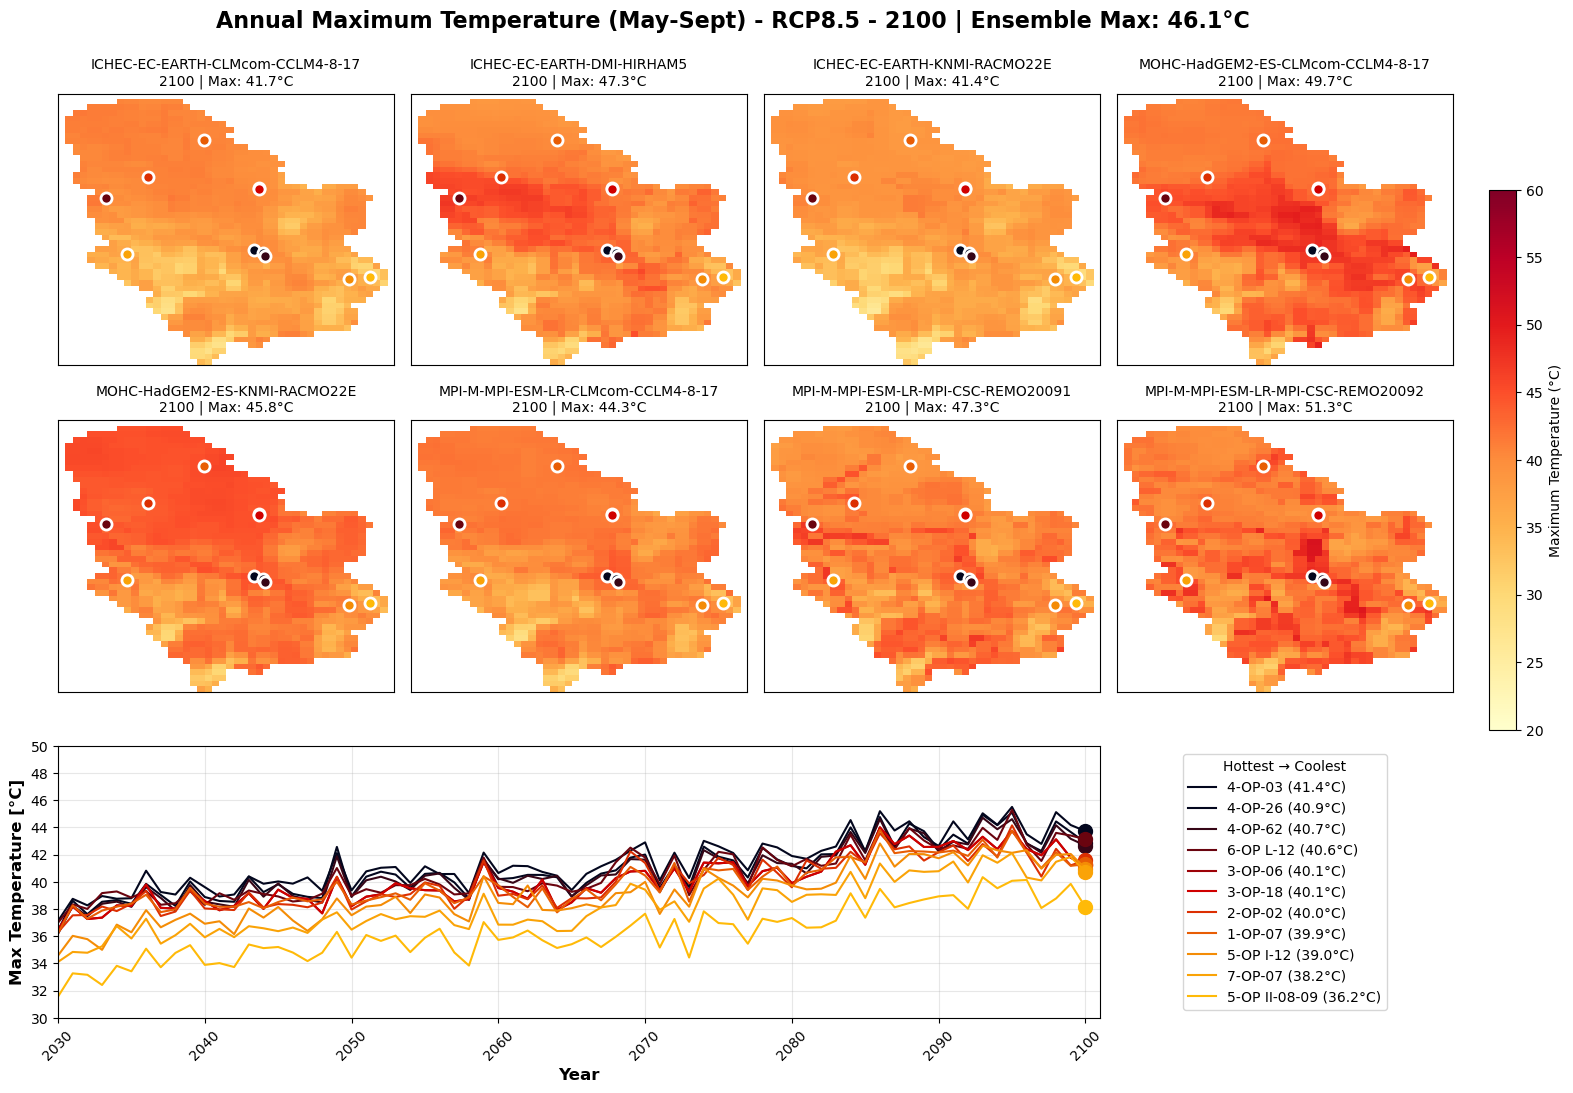

In [ ]:
# Define the color scheme (dark to light, corresponding to high to low temp)
temp_colors = ["#03071e","#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]

# Calculate average temperature for each section across all years
section_avg_temps = {}
for section_name, temp_series in section_temps.items():
    section_avg_temps[section_name] = np.mean(temp_series)

# Sort sections by average temperature (high to low)
sorted_sections = sorted(section_avg_temps.items(), key=lambda x: x[1], reverse=True)
sorted_section_names = [item[0] for item in sorted_sections]

# Assign colors based on temperature ranking
color_dict = {}
n_sections = len(sorted_section_names)
for i, section_name in enumerate(sorted_section_names):
    # Map section rank to color index
    color_idx = int(i * (len(temp_colors) - 1) / (n_sections - 1)) if n_sections > 1 else 0
    color_dict[section_name] = temp_colors[color_idx]

print("Sections ordered by average temperature (hottest to coolest):")
for section_name, avg_temp in sorted_sections:
    print(f"{section_name}: {avg_temp:.1f}°C")

# Create figure with GridSpec
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[3, 3, 3], hspace=0.2, wspace=0.05)

# Create map subplots (top two rows)
map_axes = []
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        map_axes.append(ax)

# Create line plot subplot (bottom row)
ax_line = fig.add_subplot(gs[2, :3])
ax_legend = fig.add_subplot(gs[2, 3])

# Create space for shared colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.015, 0.45])

# Create initial plots
im_plots = []
for i, model_name in enumerate(model_names):
    ax = map_axes[i]
    
    # Initial data (first year)
    initial_data = filtered_tasmax[model_name]['tasmax'].isel(time=0).values
    
    im = ax.imshow(initial_data, cmap='YlOrRd', vmin=20, vmax=60, 
                   extent=[lons.min(), lons.max(), lats.min(), lats.max()], 
                   origin='lower', aspect='auto')
    
    ax.set_title(f"{model_name}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    im_plots.append(im)

# Add shared colorbar
fig.colorbar(im_plots[0], cax=cbar_ax, label='Maximum Temperature (°C)')
cbar_ax.set_yticks(np.arange(20, 65, 5))

# Add loan section markers to each map (ordered by temperature)
for section_name in sorted_section_names:
    if section_name in loan_segments:
        lon, lat = loan_segments[section_name]
        for ax in map_axes:
            ax.plot(lon, lat, 'o', color=color_dict[section_name], 
                    markersize=8, markeredgecolor='white', markeredgewidth=2,
                    zorder=10)

# Set up line plot
ax_line.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_line.set_ylabel('Max Temperature [°C]', fontsize=12, fontweight='bold')
ax_line.set_xlim(0, len(years))

# Set y-axis limits
ax_line.set_ylim(30, 50)
ax_line.set_yticks(np.arange(30, 51, 2))
ax_line.grid(alpha=0.3)

# Create empty line objects for loan sections (in temperature order)
lines = {}
dots = {}
for section_name in sorted_section_names:
    color = color_dict[section_name]
    line, = ax_line.plot([], [], color=color, linewidth=1.5, label=f"{section_name} ({section_avg_temps[section_name]:.1f}°C)")
    dot, = ax_line.plot([], [], 'o', color=color, markersize=10)
    lines[section_name] = line
    dots[section_name] = dot

# Create legend in separate subplot (ordered by temperature)
legend_handles = [lines[section_name] for section_name in sorted_section_names]
legend_labels = [f"{section_name} ({section_avg_temps[section_name]:.1f}°C)" for section_name in sorted_section_names]

ax_legend.legend(handles=legend_handles, labels=legend_labels,
                loc='center', fontsize=10, ncol=1, title="Hottest → Coolest")
ax_legend.axis('off')

# Set x-axis labels
xtick_positions = range(0, len(years), 10)
xtick_labels = [str(years[i]) for i in xtick_positions]
ax_line.set_xticks(xtick_positions)
ax_line.set_xticklabels(xtick_labels, rotation=45)

def animate(frame):
    current_year = years[frame]
    
    # Calculate ensemble mean max temperature for this frame
    frame_temps = []
    for model_name in model_names:
        model_max = filtered_tasmax[model_name]['tasmax'].isel(time=frame).max().values
        frame_temps.append(model_max)
    
    ensemble_mean_max = np.nanmean(frame_temps)
    
    # Update each map subplot
    for i, model_name in enumerate(model_names):
        data = filtered_tasmax[model_name]['tasmax'].isel(time=frame).values
        model_max = filtered_tasmax[model_name]['tasmax'].isel(time=frame).max().values
        im_plots[i].set_data(data)
        map_axes[i].set_title(f"{model_name}\n{current_year} | Max: {model_max:.1f}°C", fontsize=10)
    
    # Update main title
    fig.suptitle(f'Annual Maximum Temperature (May-Sept) - RCP8.5 - {current_year} | '
                 f'Ensemble Max: {ensemble_mean_max:.1f}°C', 
                 fontsize=16, y=0.95, weight='bold')
    
    # Update line plot - show data up to current frame
    x_data = list(range(frame + 1))
    
    # Update lines and dots for loan sections
    for section_name in sorted_section_names:
        if section_name in section_temps:
            lines[section_name].set_data(x_data, section_temps[section_name][:frame+1])
            dots[section_name].set_data([frame], [section_temps[section_name][frame]])
    
    return im_plots + list(lines.values()) + list(dots.values())

# Create animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(years),  # Changed back to full length
    interval=300,
    blit=True
)

# Save animation
ani.save('tasmax_loan_sections_rcp85_2030-2100.gif', 
         writer="pillow", 
         savefig_kwargs={'facecolor': 'white', 'pad_inches': 0.1})

plt.show()